<a href="https://colab.research.google.com/github/pedrodatascientist/Cienciadedados/blob/master/Teste_BI_Nupay_for_Business.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ***BI CASE -  Nupay for Business***

1 - Your colleague Jane Hopper, the analyst in charge of analysing customer
behaviour, who directly
consumes data from the Data Warehouse Environment, needs to get all the account's monthly
balances between Jan/2020 and Dec/2020. She wasn't able to do it alone, and asked for your help.
Add to your resolution the SQL query used to retrieve the data needed (the necessary tables in csv
format were sent along with this pdf, on folder tables/). Feel free to use the dialect of your choice, but
please specify the SQL engine.

# Using Spark(Pyspark) environment to Load Data

In [ ]:
!pip install pyspark

In [ ]:
from pyspark.sql import *
from pyspark.sql.functions import col
from pyspark.sql.types import StructType,StructField
from pyspark.sql.types import StringType, IntegerType, ArrayType
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
spark = SparkSession.builder.getOrCreate()

In [ ]:
spark.getActiveSession()

# Read Data from Data wharehouse to Drive, could be a Data lake also

In [ ]:
import os

# file name with extension
file_name = os.path.basename('/root/file.ext')

# file name without extension
print(os.path.splitext(file_name))

('file', '.ext')


In [ ]:
path = os.path.basename('/root/file.ext')
names = []
for filess in path:
  name = os.path.splitext(file_name[0])




In [ ]:
acounts = spark.read.option("header", True)\
               .csv('/content/acounts.csv')

In [ ]:
city = spark.read.option("header", True)\
               .csv('/content/city.csv')

In [ ]:
country = spark.read.option("header", True)\
               .csv('/content/country.csv')

In [ ]:
customers = spark.read.option("header", True)\
               .csv('/content/customers.csv')

In [ ]:
d_month = spark.read.option("header", True)\
               .csv('/content/d_month.csv')

In [ ]:
d_time = spark.read.option("header", True)\
               .csv('/content/d_time.csv')

In [ ]:
d_week = spark.read.option("header", True)\
               .csv('/content/d_week.csv')

In [ ]:
d_weekday = spark.read.option("header", True)\
               .csv('/content/d_weekday.csv')

In [ ]:
d_year = spark.read.option("header", True)\
               .csv('/content/d_year.csv')

In [ ]:
pix_movements = spark.read.option("header", True)\
               .csv('/content/pix_movements.csv')

In [ ]:
state = spark.read.option("header", True)\
               .csv('/content/state.csv')

In [ ]:
tranfer_outs = spark.read.option("header", True)\
               .csv('/content/tranfer_outs.csv')

In [ ]:
tranfers_ins = spark.read.option("header", True)\
               .csv('/content/tranfers_ins.csv')

Creating Temp View in Spark Core

---



In [ ]:
acounts.createOrReplaceTempView("acounts")
city.createOrReplaceTempView("city")
country.createOrReplaceTempView("country")
customers.createOrReplaceTempView("customers")
d_month.createOrReplaceTempView("d_month")
d_time.createOrReplaceTempView("d_time")
d_week.createOrReplaceTempView("d_week")
d_weekday.createOrReplaceTempView("d_weekday")
d_year.createOrReplaceTempView("d_year")
pix_movements.createOrReplaceTempView("pix_movements")
state.createOrReplaceTempView("state")
tranfer_outs.createOrReplaceTempView("tranfer_outs")
tranfers_ins.createOrReplaceTempView("tranfers_ins")

In [ ]:
df_analytical = spark.sql(
"""SELECT to_date(from_unixtime(pix_completed_at/1000)) AS completed_at,
       acounts.account_branch,
       acounts.account_number,
       acounts.account_check_digit,
       acounts.customer_id,
       pix_movements.account_id,
       CASE
           WHEN in_or_out = 'pix_out' THEN pix_amount
           ELSE 0
       END AS pix_out,
       CASE
           WHEN in_or_out = 'pix_in' THEN pix_amount
           ELSE 0
       END AS pix_in
FROM pix_movements
INNER JOIN acounts ON acounts.account_id = pix_movements.account_id
WHERE from_unixtime(pix_completed_at/1000) BETWEEN '2020-01-01' AND '2020-12-31'
  AND pix_movements.status = 'completed'""")

In [ ]:
df_analytical.show(10, False)

+------------+--------------+--------------+-------------------+-------------------+------------------+-------+------+
|completed_at|account_branch|account_number|account_check_digit|customer_id        |account_id        |pix_out|pix_in|
+------------+--------------+--------------+-------------------+-------------------+------------------+-------+------+
|2020-01-22  |7763          |38218         |9                  |3287830764476260864|509281836645315264|1894.77|0     |
|2020-04-19  |7763          |38218         |9                  |3287830764476260864|509281836645315264|419.79 |0     |
|2020-12-30  |7763          |38218         |9                  |3287830764476260864|509281836645315264|0      |943.61|
|2020-04-04  |7763          |38218         |9                  |3287830764476260864|509281836645315264|0      |124.66|
|2020-06-01  |7763          |38218         |9                  |3287830764476260864|509281836645315264|775.96 |0     |
|2020-08-23  |7763          |38218         |9   

In [ ]:
df_analytical.createOrReplaceTempView("df_analytical")

In [ ]:
df_balance = spark.sql("""
SELECT DISTINCT customer_id,
                month_balance,
                account_id,
                CAST(SUM(soma_pix_out) OVER (PARTITION BY customer_id
                                             ORDER BY month_balance) AS FLOAT) AS Pix_Out,
                CAST(SUM(soma_pix_in) OVER (PARTITION BY customer_id
                                            ORDER BY month_balance) AS FLOAT) AS Pix_In,
                CAST(SUM(soma_pix_in) OVER (PARTITION BY customer_id
                                            ORDER BY month_balance) - SUM(soma_pix_out) OVER (PARTITION BY customer_id
                                                                                              ORDER BY month_balance) AS FLOAT) AS Balance
FROM
  (SELECT month(to_date(from_unixtime(pix_completed_at/1000))) AS month_balance,
          acounts.customer_id,
          pix_movements.account_id,
          CASE
              WHEN in_or_out = 'pix_out' THEN pix_amount
              ELSE 0
          END AS soma_pix_out,
          CASE
              WHEN in_or_out = 'pix_in' THEN pix_amount
              ELSE 0
          END AS soma_pix_in
   FROM pix_movements
   INNER JOIN acounts ON acounts.account_id = pix_movements.account_id
   WHERE from_unixtime(pix_completed_at/1000) BETWEEN '2020-01-01' AND '2020-12-31'
     AND pix_movements.status = 'completed')
                      """)

In [ ]:
#Filtrando e Exibindo
df_balance.filter(df_balance.account_id == '648355199840677888').show(12)

+-------------------+-------------+------------------+--------+--------+---------+
|        customer_id|month_balance|        account_id| Pix_Out|  Pix_In|  Balance|
+-------------------+-------------+------------------+--------+--------+---------+
|2027295864097128704|            1|648355199840677888|     0.0|  739.49|   739.49|
|2027295864097128704|            2|648355199840677888| 7816.82| 2551.39| -5265.43|
|2027295864097128704|            3|648355199840677888|11191.25| 5379.89| -5811.36|
|2027295864097128704|            4|648355199840677888|13259.44| 7673.35| -5586.09|
|2027295864097128704|            5|648355199840677888|13259.44|10457.79| -2801.65|
|2027295864097128704|            6|648355199840677888|14986.88|12226.64| -2760.24|
|2027295864097128704|            7|648355199840677888|20183.74|12226.64|  -7957.1|
|2027295864097128704|            8|648355199840677888|21664.12|15609.58| -6054.54|
|2027295864097128704|            9|648355199840677888|23511.85|19245.19| -4266.66|
|202

**2 -  Better database design**

Imagine now that you could remodel the data warehouse environment freely, you may consider that
Nubank is always evolving with new products and it is also expanding to new countries, so our data
warehouse needs to accommodate all these incoming changes. Keep in mind that the new products
sometimes are not related to peer-to-peer transactions – for example: life insurance, lending and
rewards – and some of them might be available only in some countries. Knowing all of that, which
modifications would you propose and why? Remember that other analysts will be using the same
structure, so it should be as clear as possible. Feel free to change, remove or add tables/fields to
generate a better database design.

**We could modify some tables in tables like:**

Create a unique table call 'd_time' instead of several tables, decreasing numbem of joins.

Create a unique table 'location'.

Create especifically colunms in fact tables to control the Type of transactions.(Pix, Transfers)

Creates new tables or datawarehouse/datamarts to receive new products.

Create a Datalake before Production Environment in Data Architecture.

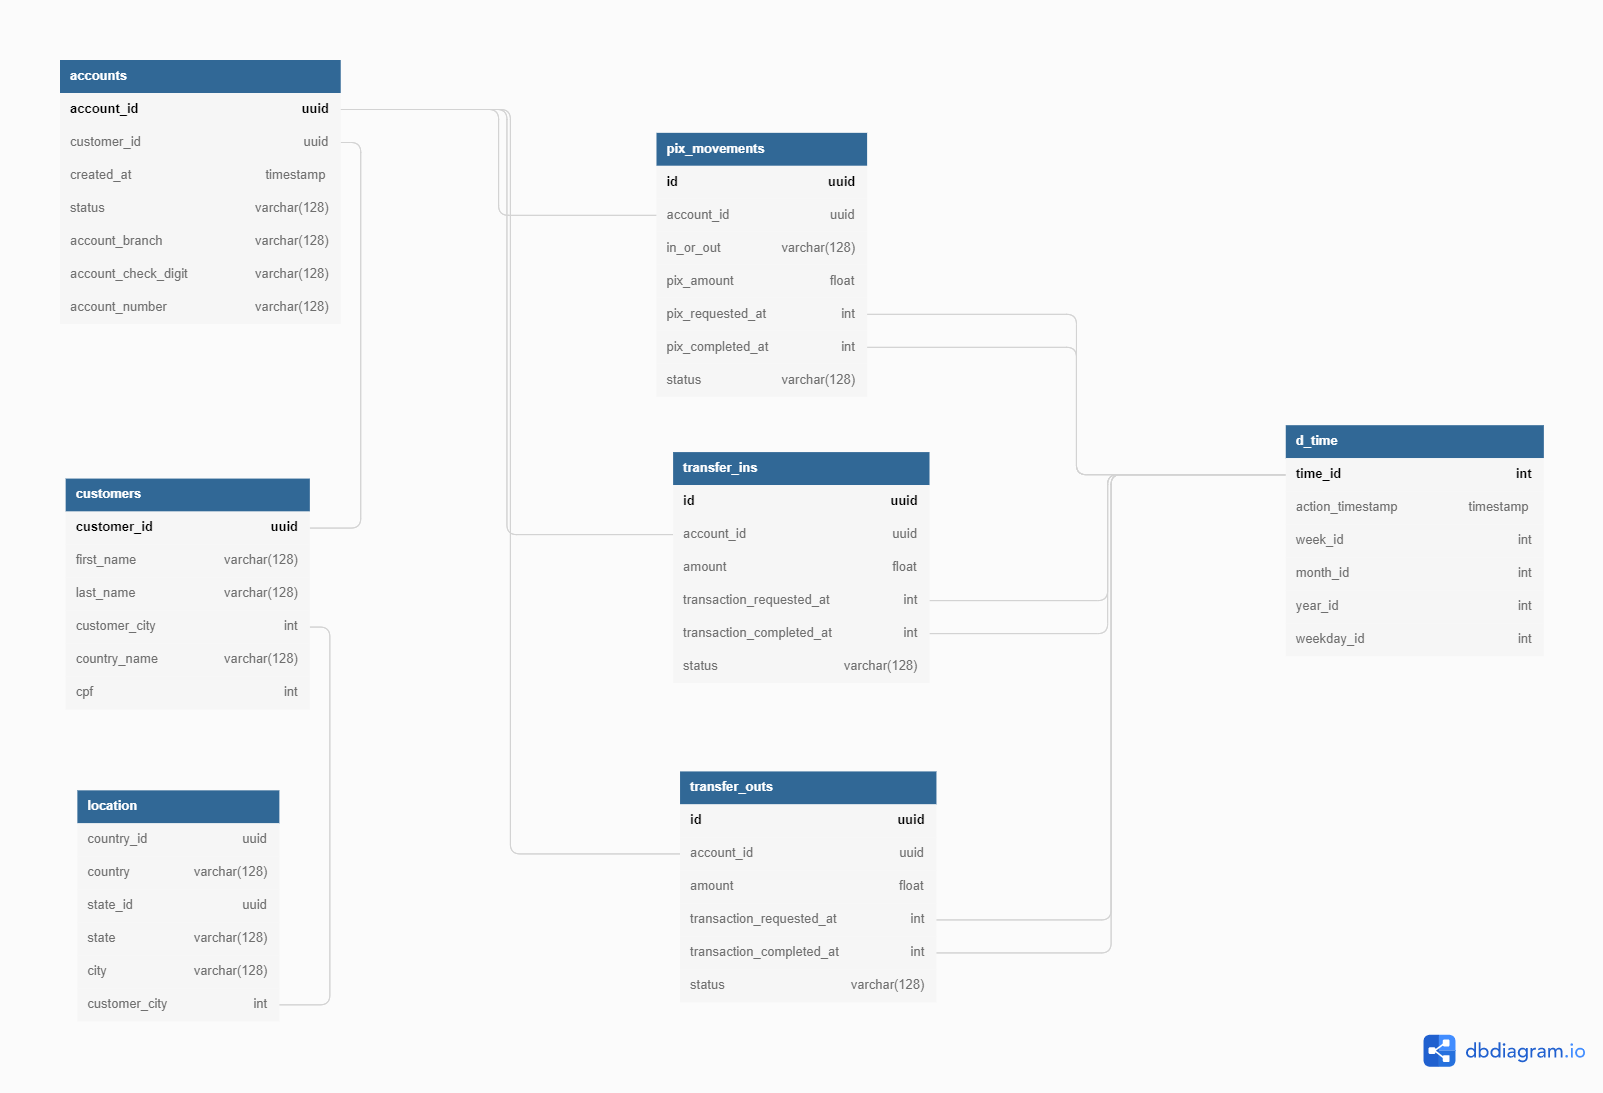


3 - In order to change our data warehouse above with your suggestions, we need to come up with a
migration plan, since many people are already consuming data from it. Which strategy would you
propose in order to implement those changes and put these changes into production?

Create a Data lake/Delta lake to receive data from Production environment, conecting Services with tecnolgies like  Spark/HDFS/DBFS.

1 - Make data inventory, mapping all requisites of databases and tables("deep dive")

1 - Create infrastructure in parallel with our operation, choosing(Cloud/On-premise)

2 - Create conections services with Data lake/Delta Lake and ETL process

3 - Create reports and analytical environment


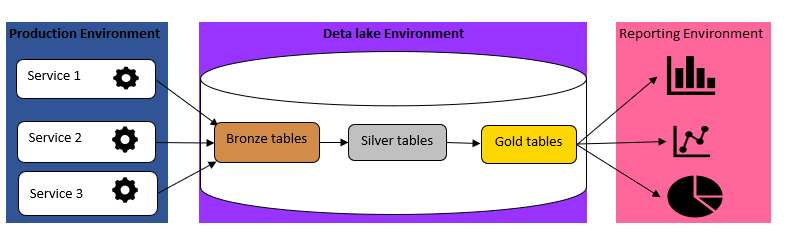

4 - Jane's friend, Pepino, wants to know how well PIX is doing inside Nubank. For that, he wants your
help to come up with indicators that can be used to track the performance of the product. Which metrics would you suggest to track it and why?

We could suggest

Growth over time, to check the target of a company

Conversion rate, to follow our servicce(pix complete and failed)

Rate of use(how many customer are using pix?)


In [ ]:
import plotly
import plotly.offline as py
from plotly.offline import plot, iplot
plotly.offline.init_notebook_mode(connected=True)
import plotly.io as pio
pio.renderers
pio.renderers.default ='colab'
import plotly.graph_objects as go
import plotly.express as px

In [ ]:
df_analytical = df_analytical.withColumn("pix_out",df_analytical.pix_out.cast('float'))
df_analytical2 = df_analytical.groupBy("completed_at").sum("pix_out").orderBy('completed_at').toPandas()
df_analytical2.head()

completed_at   sum(pix_out)
0   2020-01-01  335098.330564
1   2020-01-02  348952.269909
2   2020-01-03  353138.960393
3   2020-01-04  301672.109893
4   2020-01-05  312222.089819

In [ ]:
pix_movements.select('status')
data = [go.Scatter(
          x=df_analytical2['completed_at'],
          y=df_analytical2['sum(pix_out)'])]
py.iplot(data)

In [ ]:
df_status = pix_movements.select('status','pix_amount').toPandas()
data2 = px.pie(df_status, values='pix_amount', names='status')
py.iplot(data2)

In [ ]:
df_user_pix = spark.sql(
"""SELECT month(to_date(from_unixtime(pix_completed_at/1000))) AS completed_at,
       acounts.customer_id,
       pix_movements.account_id,
       CASE
           WHEN in_or_out = 'pix_out' THEN pix_amount
           ELSE 0
       END AS pix_out,
       CASE
           WHEN in_or_out = 'pix_in' THEN pix_amount
           ELSE 0
       END AS pix_in
FROM pix_movements
FULL JOIN acounts ON acounts.account_id = pix_movements.account_id
WHERE from_unixtime(pix_completed_at/1000) BETWEEN '2020-01-01' AND '2020-12-31'
AND customer_id is null
""")
df_user_pix.show(5)

+------------+-------------------+-------------------+-------+------+
|completed_at|        customer_id|         account_id|pix_out|pix_in|
+------------+-------------------+-------------------+-------+------+
|          12|3209893558372028928|1000667155163612544|      0|1433.0|
|           1|3209893558372028928|1000667155163612544|      0| 706.7|
|           3|3209893558372028928|1000667155163612544|1768.04|     0|
|          12|3209893558372028928|1000667155163612544|      0|378.95|
|           8|3209893558372028928|1000667155163612544| 1724.1|     0|
+------------+-------------------+-------------------+-------+------+
only showing top 5 rows



In [ ]:
df_to_report_2 = spark.sql(
"""SELECT *, month(to_date(from_unixtime(pix_completed_at/1000))) AS completed_at FROM pix_movements
""")
df_to_report_2.show(5)

+-------------------+------------------+---------+----------+----------------+----------------+---------+------------+
|                 id|        account_id|in_or_out|pix_amount|pix_requested_at|pix_completed_at|   status|completed_at|
+-------------------+------------------+---------+----------+----------------+----------------+---------+------------+
|1362907709468179968|509281836645315264|  pix_out|   1894.77|   1579693633580|   1579693646070|completed|           1|
|2246794118022659072|509281836645315264|  pix_out|    419.79|   1587309244550|   1587309252480|completed|           4|
| 165696026045637376|509281836645315264|   pix_in|    943.61|   1609306218320|   1609306227350|completed|          12|
| 919545932589046400|509281836645315264|   pix_in|    124.66|   1586015734430|   1586015747590|completed|           4|
|2001212142240523008|509281836645315264|  pix_out|    775.96|   1590974667000|   1590974672740|completed|           6|
+-------------------+------------------+--------

In [ ]:
df3 = df_to_report_2.toPandas()
df3['pix_amount'] = df3.pix_amount.astype(float)

KeyboardInterrupt: ignored

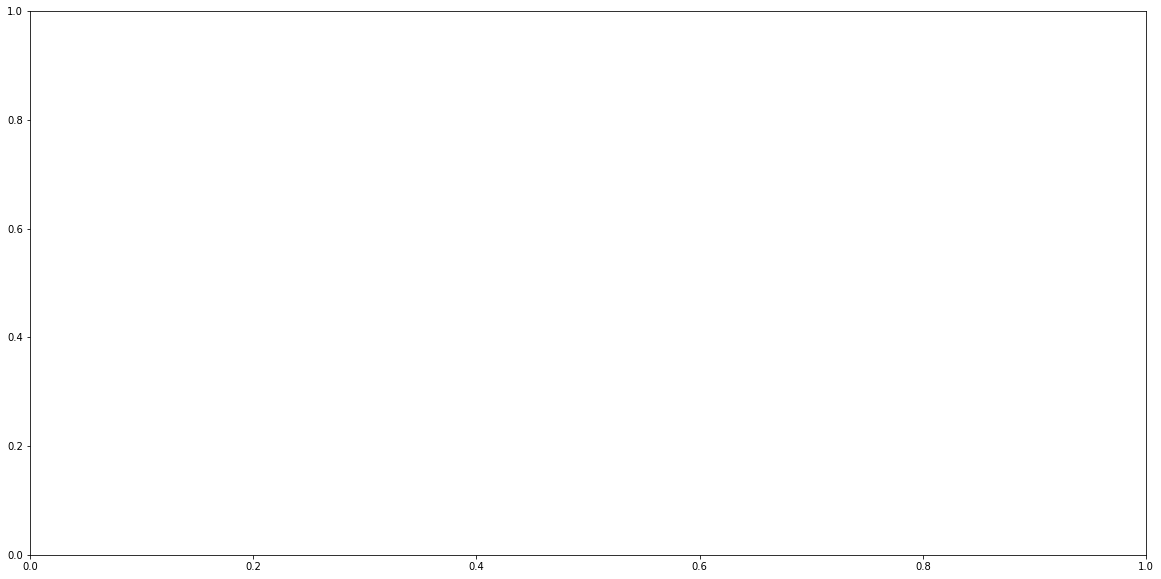

In [ ]:
plt.subplots(figsize=(20, 10))
sns.barplot(x="pix_completed_at", y='pix_amount', data=df3)